In [1]:
#%reset
import os
rundir='/space/hall3/sitestore/eccc/crd/ccrn/users/rms101/SCRIPTS/cfc/'
os.chdir(rundir)
import sys
sys.path.append('../PMODS')

import os
import cmipdata as cd
import numpy as np
import matplotlib.pyplot as plt # for basic plotting
import rms_plots_v2 as rpl
import rms_utils as rut
import matplotlib as mpl
import xarray as xr
import rms_utils_boot as rutb
from matplotlib.ticker import MultipleLocator
import glob
from scipy import stats
import pickle
import nc as nc
################settings
#mpl.style.reload_library()
plt.style.use('rms_paper')
ystart=1955;ystop=2005;nyear=ystop+1-ystart


registering cmaps
registering cmaps


1a. Calculate GM annual mean TAS timeseries LE
#####################################################

In [3]:
# =====================================
# 1. Read data
# =====================================

## model
files={};rips={}
data={};nens={};   

for forcing in ['historical','hist-noCFC','hist-noCFC-noO3','hist-noaerosol','hist-noCO2']:#files_arc.keys():
    files[forcing]=[]
    rips[forcing]=[]
    os.chdir('{}/DATA_{}_canesm5_past_{}'.format(datadir,varnm,forcing))
    #make file lists
    for i in range(1,21): #for historical-p2, 40 members available, but only 25 used here
        files[forcing].extend(glob.glob('ssie*_'+forcing+'_*r'+str(i)+'i1p2f1*'))
    #print files_arc[forcing]
    #get rips
    nens[forcing]=len(files[forcing])
    for i in range(nens[forcing]):
        rips[forcing].append(files[forcing][i].split("_")[5])
#        print forcing,rips[forcing][i]    
    #declare variables
    data[forcing]=np.zeros((nens[forcing],nyear))*np.nan  
    #read data
    for i,file in enumerate(files[forcing]):
        df=xr.open_dataset(file)
        data[forcing][i,:]=df.sel(time=slice(str(ystart),str(ystop))).siconc.data.squeeze()         
## obs
data_obs=nc.getvar('{}/DATA_SIC_obs_past/SSIE.nc'.format(datadir),'seaice_conc').squeeze()*1e-12
        
os.chdir(rundir)




In [4]:
#==========================================================
#2. Calc deltas 
#==========================================================

years=np.arange(ystart,ystop+1)

###using linear trend method
dssie={}

for forcing in sorted(files_arc.keys()):
    dssie[forcing]=np.zeros((nens[forcing]))*np.nan
    
    for i in range(nens[forcing]):
        dssie[forcing][i]=np.mean(data[forcing][i,-10::],axis=0)-np.mean(data[forcing][i,0:10],axis=0)
    print forcing,np.mean(dssie[forcing])

dssie_obs=np.mean(data_obs[-10::])-np.mean(data_obs[0:10])
print dssie_obs
### write data    
with open('DATA/dssie.pickle', 'wb') as handle:
    pickle.dump(dssie, handle, protocol=pickle.HIGHEST_PROTOCOL)



hist-noCFC -0.41307537078857415
hist-noCFC-noO3 -0.4887737441062928
hist-noCO2 0.04238530397415143
hist-noaerosol -2.14521835565567
historical -1.131273250579834
-1.5248804


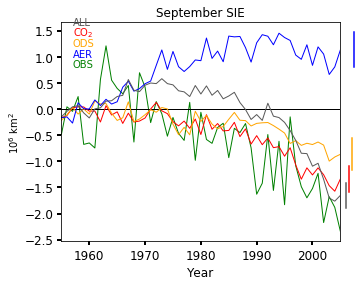

In [9]:
os.system('mkdir -p PLOTS')
labels={'historical':'ALL',
        'hist-noCFC':'FixODS',
        'hist-noCFC-noO3':'FixODSO3S',
        'hist-noaerosol':'Fixaerosol',
        'hist-noCO2':'FixCO2'}

labelsdif={'historical':'ALL',
          'hist-noCFC':'ODS', 
          'hist-noCFC-noO3':'ODSO3',
          'hist-noaerosol':'AER',
          'hist-noCO2':'CO$_2$'}

colors={'historical':[0.35,0.35,0.35],
        'hist-noCFC':'orange',
        'hist-noCFC-noO3':'brown',
        'hist-noaerosol':'blue',
        'hist-noCO2':'red'        
       }
years=np.arange(ystart,ystop+1)
#==========================================================
#2a. Plot raw timeseries 
#==========================================================
############### Setup fig
fig1, axs = plt.subplots(1,1, figsize=(5,8)); 
fig1.subplots_adjust(bottom=0.5,hspace=0.1,wspace=0.15)
ax=axs
ax.set_xlim([1955, 2005]) 
ax.set_xlabel('Year',size='large')
ax.axhline(y=0,color="black",linewidth=1)
ax.set_ylabel('10$^6$ km$^2$')

fact=1.645/np.sqrt(20) #factor to multiply standard deviation with to obtain 5-95% range on the ensemble mean

#############plot forcings ###################################
for i,forcing in enumerate(['hist-noCO2','hist-noCFC','hist-noaerosol']):
    x=data['historical']-data[forcing]#iens,iyear
    #plot timeseries
    ax.plot(years,np.mean(x,axis=0),linewidth=1, color=colors[forcing])
    #plot range
    ax.plot([2006.5+i*0.5,2006.5+i*0.5],[np.mean(x[:,-1])-fact*np.std(x[:,-1]),np.mean(x[:,-1])+fact*np.std(x[:,-1])],clip_on=False,color=colors[forcing]) 
    #x_last10=np.zeros(20); 
    #for iens in range(20): 
    #    x_last10[iens]=np.mean(x[iens,-10::],axis=0)
    #ax.plot([2007+i*1,2007+i*1],[np.mean(x_last10)-np.std(x_last10),np.mean(x_last10)+np.std(x_last10)],clip_on=False,color=colors[forcing]) 
    #legend     
    ax.text(1957,1.4-i*0.2,labelsdif[forcing],color=colors[forcing])

#############plot ALL ###################################

x=data['historical']-np.mean(data['historical'][:,0:10]) 
#plot timeseries
ax.plot(years,np.mean(x,axis=0),linewidth=1, color=colors['historical'])

#plot range
ax.plot([2006,2006],[np.mean(x[:,-1])-fact*np.std(x[:,-1]),np.mean(x[:,-1])+fact*np.std(x[:,-1])],clip_on=False,color=colors['historical']) 
#x_last10=np.zeros(20); 
#ax.plot([2006,2006],[np.mean(x_last10)-np.std(x_last10),np.mean(x_last10)+np.std(x_last10)],clip_on=False,color=colors['historical']) 
#for iens in range(20): 
#        x_last10[iens]=np.mean(x[iens,-10::],axis=0)

ax.text(1957,1.6,'ALL',color=colors['historical'])
ax.text(1957,1.4-3*0.2,'OBS',color='green',zorder=0)
#############plot obs ###################################

ax.plot(years,data_obs-np.mean(data_obs[0:10]),linewidth=1, color='green',zorder=0)
#ax.plot(years,data_obs-data_obs[0],linewidth=1, color='green',zorder=0)

#ax.scatter(2006,data_obs[-1]-np.mean(data_obs[0:10]),color='green',clip_on=False)


##title,save
rpl.add_title(ax,'September SIE')
rpl.mysavefig(fig1,'PLOTS/fig3_SSIE.png')


        
        